# Friends 감정분석 with LSTM
참고 소스 출처(링크) : 텐서플로2와 머신러닝으로 시작하는 자연어 처리(전창욱 외, 위키북스, 2020)

# 준비
라이브러리, 파라미터 세팅

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
#from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import time
import re
import json

from nltk.corpus import stopwords
from konlpy.tag import Okt

In [2]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'

BATCH_SIZE = 512
NUM_EPOCHS = 20
TEST_SIZE = 0.2
RANDOM_SEED = 42

model_name = 'rnn_classifier_eng'

# tf.random.set_seed 함수를 이용해 시드를 고정하여 학습 관련 랜덤 변수에 대한 초기 상태를 유지
tf.random.set_seed(RANDOM_SEED)

# 데이터 로드

In [3]:
def jsonToDf(file_name):
    with open(file_name, encoding = 'utf-8', mode = 'r') as file:
        json_array = json.load(file)
  
    result = pd.DataFrame.from_dict(json_array[0])

    is_first = True
    for array in json_array:
        if is_first:
            is_first = False
            continue
    
        temp_df = pd.DataFrame.from_dict(array)
        result = result.append(temp_df, ignore_index = True)

    return result

In [4]:
train_df = jsonToDf(DATA_IN_PATH+'friends_train.json')  # 학습용
dev_df = jsonToDf(DATA_IN_PATH+'friends_dev.json')  # 검증용
test_df = pd.read_csv(DATA_IN_PATH+'en_data.csv')  # 테스트(캐글) 데이터

In [5]:
print(train_df.shape)
print(dev_df.shape)
print(test_df.shape)

(10561, 4)
(1178, 4)
(1623, 5)


In [6]:
train_df.head()

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tr...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030


In [7]:
dev_df.head()

,speaker,utterance,emotion,annotation
0,Phoebe,"Oh my God, hes lost it. Hes totally lost it.",non-neutral,0002120
1,Monica,What?,surprise,1000130
2,Ross,"Or! Or, we could go to the bank, close our acc...",neutral,3000200
3,Chandler,Youre a genius!,joy,0500000
4,Joey,"Aww, man, now we wont be bank buddies!",sadness,0040100


In [8]:
test_df.head()

,id,i_dialog,i_utterance,speaker,utterance
0,0,0,0,Phoebe,"Alright, whadyou do with him?"
1,1,0,1,Monica,Oh! You're awake!
2,2,0,2,Joey,Then you gotta come clean with Ma! This is not...
3,3,0,3,Mr. Tribbiani,"Yeah, but this is"
4,4,0,4,Joey,I don't wanna hear it! Now go to my room!


# 데이터 탐색(EDA)

(-0.5, 799.5, 599.5, -0.5)

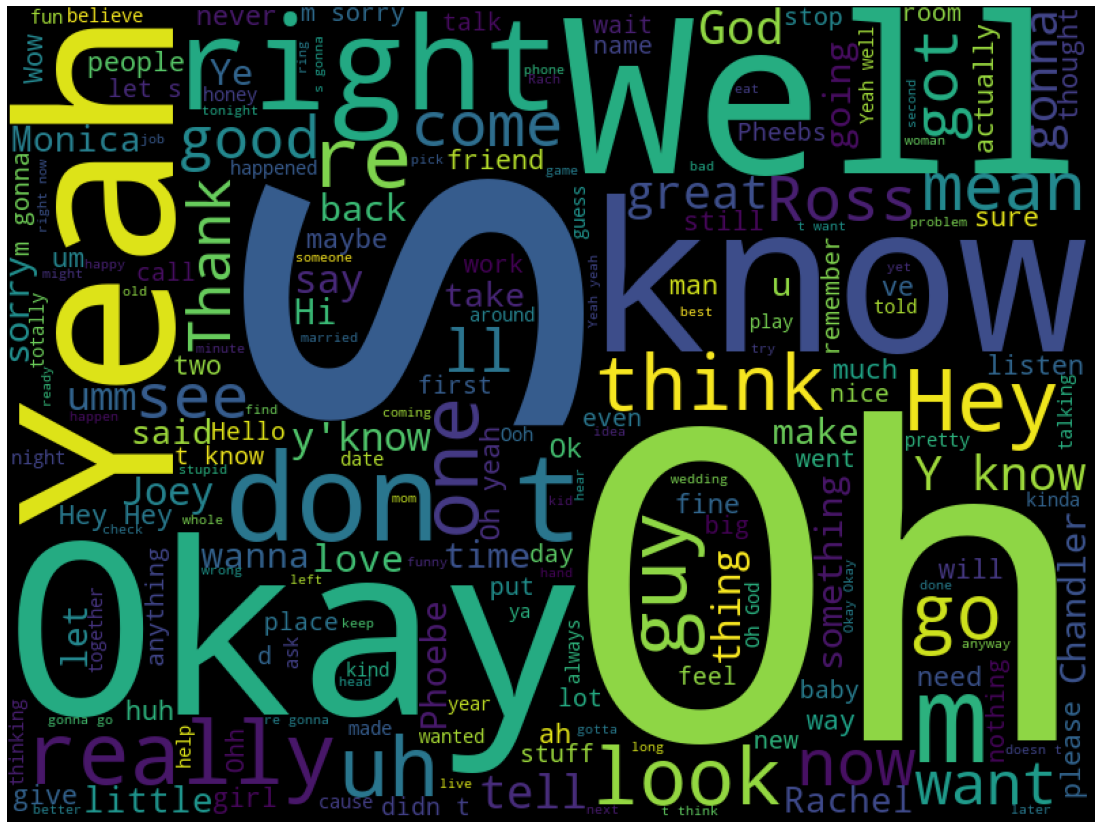

In [9]:
# 워드 클라우드 확인 (많이 사용된 단어)
from wordcloud import WordCloud
cloud = WordCloud(width=800, height=600).generate(" ".join(train_df['utterance']))
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

# 데이터 전처리

In [10]:
def data_cleansing(train_data, dev_data, test_data, con=0):  # 0: 전처리 없음(null값 공백 치환), 1: 숫자 제거, 2: 특수문자 제거
    global train_df
    global dev_df
    global test_df
    
    train_data = jsonToDf(DATA_IN_PATH+'friends_train.json')  # 학습용
    dev_data = jsonToDf(DATA_IN_PATH+'friends_dev.json')  # 검증용
    test_data = pd.read_csv(DATA_IN_PATH+'en_data.csv')  # 테스트(캐글) 데이터
   
    train_data.drop(['speaker','annotation'], axis=1, inplace=True)
    dev_data.drop(['speaker','annotation'], axis=1, inplace=True)
    test_data.drop(['i_dialog','i_utterance','speaker'], axis=1, inplace=True)

    train_df = train_data.copy()
    dev_df = dev_data.copy()
    test_df = test_data.copy()
    
    if con == 1:  # 숫자 제거 & Null 치환(공백), row 제거 없음
        # 정규 표현식을 이용해 숫자를 공백으로 변경(정규 표현식으로 \d는 숫자를 의미)
        train_df = train_df.fillna(' ')
        train_df['utterance'] = train_df['utterance'].apply( lambda x : re.sub(r"\d+", " ", x) )  # 숫자 제거
        dev_df = dev_df.fillna(' ')
        dev_df['utterance'] = dev_df['utterance'].apply( lambda x : re.sub(r"\d+", " ", x) )  # 숫자 제거
        test_df = test_df.fillna(' ')
        test_df['utterance'] = test_df['utterance'].apply( lambda x : re.sub(r"\d+", " ", x) )  # 숫자 제거
        
    elif con == 2:  # 특수문자 제거 & Null 치환(공백), row 제거 없음
        train_df = train_df.fillna(' ')
        train_df['utterance'] = train_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(특수문자 제거)
        dev_df = dev_df.fillna(' ')
        dev_df['utterance'] = dev_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(특수문자 제거)
        test_df = test_df.fillna(' ')
        test_df['utterance'] = test_df['utterance'].str.replace("[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\x92]","") # 정규 표현식 수행(특수문자 제거)
        
    else:
        train_df = train_df.fillna(' ')
        dev_df = dev_df.fillna(' ')
        test_df = test_df.fillna(' ')
    
    print('전처리 후 학습 데이터 :',train_df.shape)
    print('전처리 후 검증 데이터 :',dev_df.shape)
    print('전처리 후 테스트 데이터 :',test_df.shape)


In [11]:
# 데이터 전처리 선택
data_cleansing(train_df, dev_df, test_df, con=2)  # 0: 전처리 없음(null값 공백 치환), 1: 특수문자 제거, 2: 영어이외 제거

전처리 후 학습 데이터 : (10561, 2)
전처리 후 검증 데이터 : (1178, 2)
전처리 후 테스트 데이터 : (1623, 2)


In [12]:
clean_train_review = train_df['utterance']
clean_dev_review = dev_df['utterance']
clean_test_review = test_df['utterance']

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)

train_sequences = tokenizer.texts_to_sequences(clean_train_review)
dev_sequences = tokenizer.texts_to_sequences(clean_dev_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index # 단어 사전 형태
word_vocab["<PAD>"] = 0

In [14]:
print("전체 단어 개수: ", len(word_vocab))

전체 단어 개수:  6183


In [15]:
word_vocab

{'you': 1,
 'i': 2,
 'the': 3,
 'to': 4,
 'a': 5,
 'and': 6,
 'oh': 7,
 'it': 8,
 'that': 9,
 'what': 10,
 'im': 11,
 'is': 12,
 'no': 13,
 'this': 14,
 'me': 15,
 'okay': 16,
 'so': 17,
 'yeah': 18,
 'my': 19,
 'just': 20,
 'of': 21,
 'in': 22,
 'have': 23,
 'well': 24,
 'we': 25,
 'its': 26,
 'do': 27,
 'dont': 28,
 'hey': 29,
 'know': 30,
 'on': 31,
 'all': 32,
 'not': 33,
 'are': 34,
 'for': 35,
 'right': 36,
 'was': 37,
 'with': 38,
 'be': 39,
 'but': 40,
 'go': 41,
 'thats': 42,
 'your': 43,
 'like': 44,
 'gonna': 45,
 'get': 46,
 'here': 47,
 'out': 48,
 'really': 49,
 'youre': 50,
 'yknow': 51,
 'can': 52,
 'about': 53,
 'think': 54,
 'up': 55,
 'he': 56,
 'were': 57,
 'uh': 58,
 'look': 59,
 'there': 60,
 'her': 61,
 'now': 62,
 'how': 63,
 'one': 64,
 'at': 65,
 'if': 66,
 'got': 67,
 'mean': 68,
 'see': 69,
 'come': 70,
 'god': 71,
 'him': 72,
 'why': 73,
 'sorry': 74,
 'want': 75,
 'did': 76,
 'ross': 77,
 'cant': 78,
 'she': 79,
 'good': 80,
 'tell': 81,
 'guys': 82,
 'joe

In [16]:
train_word_counts = train_df['utterance'].apply(lambda x:len(x.split(' ')))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.


Text(0, 0.5, 'Number of reviews')

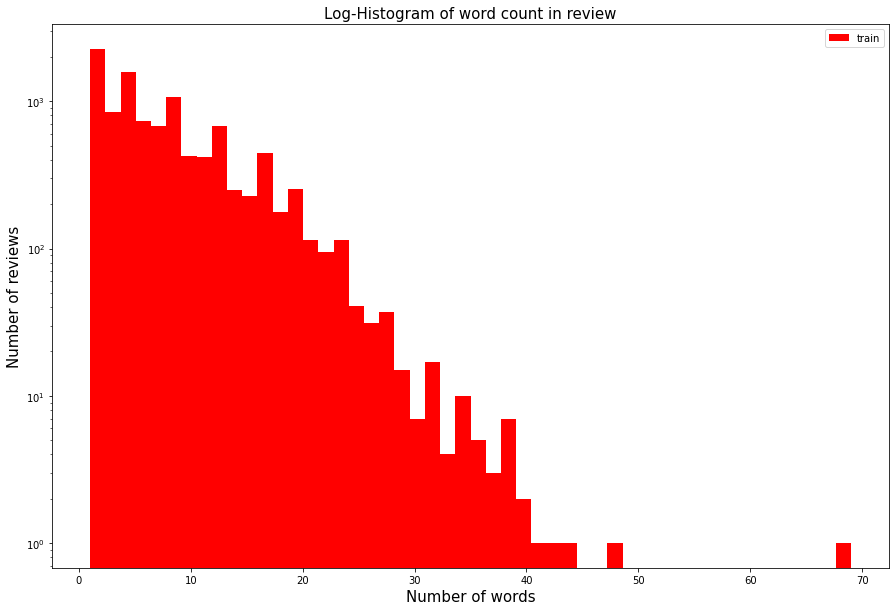

In [17]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of reviews', fontsize=15)

In [18]:
print('발화 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('발화 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('발화 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('발화 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('발화 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('발화 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('발화 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

발화 단어 개수 최대 값: 69
발화 단어 개수 최소 값: 1
발화 단어 개수 평균 값: 7.87
발화 단어 개수 표준편차: 6.31
발화 단어 개수 중간 값: 6.0
발화 단어 개수 제 1 사분위: 3.0
발화 단어 개수 제 3 사분위: 11.0


In [19]:
MAX_SEQUENCE_LENGTH = 9

train_data_array = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 학습 데이터를 벡터화
dev_data_array = pad_sequences(dev_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 검증 데이터를 벡터화
test_data_array = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 검증 데이터를 벡터화

In [20]:
# Friends 감정 딕셔너리 생성
emoset = {'non-neutral': 0,
          'neutral': 1, 
          'joy': 2,
          'sadness': 3,
          'fear': 4,
          'anger': 5,
          'surprise': 6,
          'disgust': 7}

In [21]:
# 'label' 컬럼 신규
#for emo in train_df['emotion'][:10]:  print(emo, emoset[emo])
train_df['label'] = [emoset[emo] for emo in train_df['emotion']]
dev_df['label'] = [emoset[emo] for emo in dev_df['emotion']]

In [22]:
# 학습, 검증(Origianl Testset) 데이터 레이블 넘파이 배열 처리
y_train = np.array(train_df['label'])
y_dev = np.array(dev_df['label'])

# 모델 생성

### 파라미터 정의
모델에 필요한 하이퍼파라미터를 정의한다. 각 모델 레이어 차원 수나 드롭아웃을 정하는 하이퍼파라미터 명칭은 key에, 키에 해당하는 하이퍼파라미터 명칭에 대한 값은 value에 입력한다.

모델에 필요한 하이퍼파라미터 값으로 에폭 수, 배치 크기, 단어 사전의 크기, 임베딩 크기를 지정한다. 단어 사전의 크기는 데이터 정보를 담은 딕셔너리에서 받아오고, 임베딩 크기는 128로 설정한다.

In [23]:
MAX_LEN = train_data_array.shape[1]

kargs = {'model_name': model_name,
         'vocab_size': len(word_vocab),
         'embedding_dimension': 100,
         'dropout_rate': 0.2,  # 0.2
         'lstm_dimension': 150,  # 150
         'dense_dimension': 150,  # 150
         'output_dimension':8}

In [24]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

텍스트 워드 임베딩 벡터를 위해 layers.Embedding 객체를 생성한다. 이때 입력 파라미터로 데이터 사전 수와 단어 임베딩 차원 수를 입력한다.

RNNClassifier 클래스에서는 RNN 계열 모델 중 하나인 LSTM을 2개의 레이어로 활용한다. LSTM을 활용하기 위해서는 tf.keras.layers.LSTM 객체를 생성한다. 두 개의 LSTM 레이어를 활용해 마지막 시퀀스의 은닉 상태 벡터를 얻기 위해서는 첫 레이어에서 시퀀스 은닉 상태 벡터를 출력해서 다음 레이어에 입력할 시퀀스 벡터를 구성하고, 마지막 레이어에서는 시퀀스의 마지막 스텝의 은닉 상태 벡터를 출력해야 한다.

RNN 레이어에서 출력한 상태 벡터는 피드 포워드 네트워크를 거치게 된다. 여기서는 tf.keras.layers.Dense를 통해 객체를 생성해 피드 포워드 네트워크를 구성한다.

# 모델 학습

In [25]:
model = RNNClassifier(**kargs)

# 학습 프로세스 설정 (sparse_categorical_crossentropy 기반)
from keras import optimizers
model.compile(
            optimizer='rmsprop',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

# optimizer='sgd'
# optimizer='adam'
# optimizer='rmsprop'
# optimizer=optimizers.RMSprop(lr=0.001)
# optimizer=tf.keras.optimizers.Adam(1e-4)

검증 정확도를 통한 EarlyStopping 기능과 모델 저장 방식을 지정하고,<br>
모델을 검증하기 위한 검증 데이터도 model.fit 안에 있는 validation_split로 지정한 다음 학습을 시작한다.

In [26]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_sparse_categorical_accuracy', min_delta=0.0001, patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights_rnn_friends.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/rnn_classifier_eng -- Folder already exists 



In [27]:
history = model.fit(train_data_array, y_train, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=TEST_SIZE, callbacks=[earlystop_callback, cp_callback])

Epoch 1/20
12/17 [====================>.........] - ETA: 0s - loss: 1.7524 - sparse_categorical_accuracy: 0.4202
Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.44676, saving model to ./data_out/rnn_classifier_eng/weights_rnn_friends.h5
17/17 [==============================] - 1s 35ms/step - loss: 1.7141 - sparse_categorical_accuracy: 0.4273 - val_loss: 1.5790 - val_sparse_categorical_accuracy: 0.4468
Epoch 2/20
13/17 [=====================>........] - ETA: 0s - loss: 1.5960 - sparse_categorical_accuracy: 0.4518
Epoch 00002: val_sparse_categorical_accuracy did not improve from 0.44676
17/17 [==============================] - 0s 10ms/step - loss: 1.5973 - sparse_categorical_accuracy: 0.4508 - val_loss: 1.5724 - val_sparse_categorical_accuracy: 0.4468
Epoch 3/20
15/17 [=========================>....] - ETA: 0s - loss: 1.5588 - sparse_categorical_accuracy: 0.4487
Epoch 00003: val_sparse_categorical_accuracy improved from 0.44676 to 0.45433, saving model to ./data_out/

In [28]:
train_preds = model.predict(train_data_array)

preds = []
for i, pred in enumerate(train_preds):
    result = np.argmax(pred)
    preds.append(result)

In [29]:
from sklearn.metrics import f1_score
f1 = f1_score(y_train, preds, average='weighted')
print('F1 Score : {:.5f}'.format(f1))

F1 Score : 0.38342


In [30]:
from sklearn.metrics import classification_report

target_names = ['non-neutral','neutral','joy','sadness','fear','anger','surprise','disgust']

print(classification_report(y_train, preds, target_names=target_names))

              precision    recall  f1-score   support

 non-neutral       0.18      0.03      0.06      2017
     neutral       0.53      0.94      0.68      4752
         joy       0.00      0.00      0.00      1283
     sadness       0.20      0.10      0.13       351
        fear       0.09      0.01      0.02       185
       anger       0.29      0.03      0.05       513
    surprise       0.46      0.58      0.52      1220
     disgust       0.00      0.00      0.00       240

    accuracy                           0.50     10561
   macro avg       0.22      0.21      0.18     10561
weighted avg       0.35      0.50      0.38     10561



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# Loss, Accuracy 시각화 함수 1
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

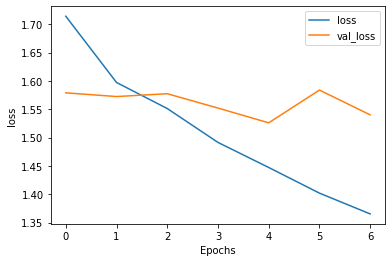

In [32]:
plot_graphs(history, 'loss')

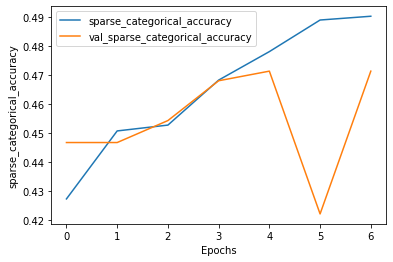

In [33]:
plot_graphs(history, 'sparse_categorical_accuracy')

In [34]:
# Loss, Accuracy 시각화 함수 2
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

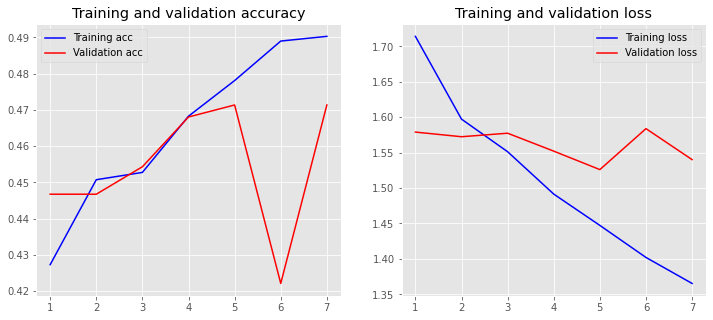

In [35]:
plot_history(history)

# 모델 평가 - 검증 데이터셋(Original Test Dataset)

테스트 데이터에 감정에 대한 라벨 값이 있는 경우이므로, 바로 결과를 확인할 수 있다.<br>
테스트 데이터를 불러올 때 학습 데이터를 전처리하는 과정과 동일하게 진행한 후 넘파이 파일로 저장한 데이터를 불러오면 된다.

In [36]:
SAVE_FILE_NM = 'weights_rnn_friends.h5' #저장된 best model 이름
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [37]:
results = model.evaluate(dev_data_array, y_dev)

37/37 [==============================] - 0s 2ms/step - loss: 1.6410 - sparse_categorical_accuracy: 0.4431


In [38]:
# optimizer='sgd' => loss: 2.0422940254211426, acc: 0.465629518032074
# optimizer='adam' => loss: 1.603613257408142, acc: 0.465629518032074
# optimizer='rmsprop' => loss: 1.5096232891082764, acc: 0.48842257261276245
# optimizer=optimizers.RMSprop(lr=0.001) => loss: 1.5041037797927856, acc: 0.484804630279541
# optimizer=tf.keras.optimizers.Adam(1e-4) => loss: 2.046860456466675, acc: 0.465629518032074
results

[1.6409928798675537, 0.4431239366531372]

In [39]:
dev_preds = model.predict(dev_data_array)

preds = []
for i, pred in enumerate(dev_preds):
    result = np.argmax(pred)
    preds.append(result)

In [40]:
from sklearn.metrics import f1_score
f1 = f1_score(y_dev, preds, average='weighted')
print('F1 Score : {:.5f}'.format(f1))

F1 Score : 0.30980


In [41]:
from sklearn.metrics import classification_report

target_names = ['non-neutral','neutral','joy','sadness','fear','anger','surprise','disgust']

print(classification_report(y_dev, preds, target_names=target_names))

              precision    recall  f1-score   support

 non-neutral       0.38      0.01      0.03       214
     neutral       0.44      0.95      0.61       491
         joy       0.00      0.00      0.00       123
     sadness       0.50      0.05      0.09        62
        fear       0.00      0.00      0.00        29
       anger       0.00      0.00      0.00        85
    surprise       0.44      0.32      0.37       151
     disgust       0.00      0.00      0.00        23

    accuracy                           0.44      1178
   macro avg       0.22      0.17      0.14      1178
weighted avg       0.34      0.44      0.31      1178



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# (참고) 제출 파일 생성

In [42]:
start = time.time()

preds = model.predict(test_data_array)

test_preds = []
for i, pred in enumerate(preds):
    result = np.argmax(pred)
    test_preds.append(result)
    print(str(i)+"번 인덱스 데이터 처리 완료 =>", pred, test_preds[i])

print("time : ", time.time() - start)

0번 인덱스 데이터 처리 완료 => [0.28323352 0.9590923  0.26022676 0.0078402  0.0054297  0.02309788
 0.09743508 0.0090802 ] 1
1번 인덱스 데이터 처리 완료 => [0.3652901  0.42409027 0.30197048 0.02061981 0.02634425 0.07725856
 0.78324157 0.04231681] 6
2번 인덱스 데이터 처리 완료 => [0.6402635  0.965046   0.16987428 0.17436667 0.07956551 0.174571
 0.03253385 0.05240716] 1
3번 인덱스 데이터 처리 완료 => [0.36859134 0.98409986 0.16494635 0.01699892 0.00880349 0.02775442
 0.03051669 0.00952342] 1
4번 인덱스 데이터 처리 완료 => [0.53392226 0.9424539  0.23174512 0.07754932 0.04237816 0.11155263
 0.06875736 0.04166966] 1
5번 인덱스 데이터 처리 완료 => [0.45033056 0.94600534 0.2367064  0.0372224  0.02236308 0.06878911
 0.08651575 0.02611352] 1
6번 인덱스 데이터 처리 완료 => [0.36316258 0.9777077  0.19583853 0.01552768 0.00867288 0.02890854
 0.04259121 0.01083207] 1
7번 인덱스 데이터 처리 완료 => [0.5467021  0.90166444 0.27443463 0.12578925 0.07684133 0.17650828
 0.11507699 0.07258061] 1
8번 인덱스 데이터 처리 완료 => [0.3383253  0.89435434 0.2932741  0.0124564  0.00967771 0.03993378
 0.20366552

 0.01821692 0.00694256] 1
529번 인덱스 데이터 처리 완료 => [0.41713935 0.99028695 0.11745442 0.02323838 0.01055379 0.02796635
 0.017174   0.00898504] 1
530번 인덱스 데이터 처리 완료 => [0.37997818 0.9715086  0.20696525 0.01924838 0.01102872 0.03729299
 0.05396358 0.01329187] 1
531번 인덱스 데이터 처리 완료 => [0.38521895 0.9628862  0.23045391 0.01887809 0.01128969 0.03897952
 0.0639504  0.01498039] 1
532번 인덱스 데이터 처리 완료 => [0.27494466 0.99277073 0.12710382 0.00914456 0.00458929 0.01256578
 0.01896542 0.0049709 ] 1
533번 인덱스 데이터 처리 완료 => [0.45276877 0.8877788  0.28822657 0.05015755 0.03452608 0.10160296
 0.17044432 0.04214945] 1
534번 인덱스 데이터 처리 완료 => [0.5213068  0.68470997 0.38315883 0.17306213 0.14430393 0.25929078
 0.35755867 0.16037808] 1
535번 인덱스 데이터 처리 완료 => [0.37257975 0.7544994  0.31416282 0.01860102 0.01719507 0.05994843
 0.40799266 0.02883828] 1
536번 인덱스 데이터 처리 완료 => [0.34864527 0.5316544  0.29704887 0.01503165 0.01777768 0.05944851
 0.70556724 0.03020406] 6
537번 인덱스 데이터 처리 완료 => [0.4878499  0.97791755 0.1653413

 0.2759836  0.01907104] 1
1070번 인덱스 데이터 처리 완료 => [0.33604184 0.09915265 0.19186617 0.01278925 0.02625452 0.05939698
 0.97413886 0.03838973] 6
1071번 인덱스 데이터 처리 완료 => [0.37804547 0.08910715 0.24830744 0.02727216 0.05213765 0.10060179
 0.9701578  0.07539283] 6
1072번 인덱스 데이터 처리 완료 => [0.29326606 0.43905836 0.23956303 0.00633475 0.00888159 0.03393628
 0.8273469  0.0154617 ] 6
1073번 인덱스 데이터 처리 완료 => [0.31157583 0.61863273 0.27905896 0.00886062 0.01025438 0.04015063
 0.6555887  0.01820638] 6
1074번 인덱스 데이터 처리 완료 => [0.4246312  0.9833319  0.1583723  0.02637178 0.01311472 0.03907407
 0.02871833 0.01248235] 1
1075번 인덱스 데이터 처리 완료 => [0.31311506 0.92212164 0.28645235 0.01054271 0.00795404 0.03327145
 0.16486052 0.01340604] 1
1076번 인덱스 데이터 처리 완료 => [0.3808771  0.9878813  0.14255132 0.01776123 0.00872489 0.02523539
 0.0231735  0.00879209] 1
1077번 인덱스 데이터 처리 완료 => [0.47156048 0.9902721  0.10531224 0.03375236 0.01440461 0.03688112
 0.0163676  0.01072767] 1
1078번 인덱스 데이터 처리 완료 => [0.30319345 0.82183164 

 0.86178595 0.01385426] 6
1608번 인덱스 데이터 처리 완료 => [0.4257364  0.97781473 0.18181181 0.02726788 0.01414621 0.04376669
 0.03511742 0.01444098] 1
1609번 인덱스 데이터 처리 완료 => [0.42361015 0.9834356  0.1596597  0.02541709 0.01249222 0.03729838
 0.02741458 0.01228442] 1
1610번 인덱스 데이터 처리 완료 => [0.48843345 0.9862157  0.13065082 0.04012518 0.01781897 0.04857467
 0.02033116 0.01412581] 1
1611번 인덱스 데이터 처리 완료 => [0.3004023  0.38924384 0.22601528 0.00651686 0.00950494 0.03450985
 0.857423   0.01620768] 6
1612번 인덱스 데이터 처리 완료 => [0.5740283  0.76919    0.36068282 0.26111564 0.1944302  0.31672627
 0.23124468 0.18673702] 1
1613번 인덱스 데이터 처리 완료 => [0.53073084 0.3940082  0.44428828 0.32417166 0.332526   0.40875506
 0.64451367 0.35687506] 6
1614번 인덱스 데이터 처리 완료 => [0.49330765 0.6252706  0.36912242 0.11328559 0.10147726 0.20364974
 0.4601189  0.1266713 ] 1
1615번 인덱스 데이터 처리 완료 => [0.52508944 0.689415   0.37411883 0.16482617 0.13563848 0.2474212
 0.35117424 0.15345784] 1
1616번 인덱스 데이터 처리 완료 => [0.5009751  0.92532307 0

In [43]:
# 감정 레이블링 위해 기존 정수형 레이블로부터 역변환
emoset_reverse = dict(zip(emoset.values(),emoset.keys()))

# 테스트 데이터의 id, 리뷰 부분을 리스트 처리
ids = list(test_df['id'])
test_utterances = list(test_df['utterance'])

# 숫자로 인코딩 된 레이블을 감정명으로 재매칭
emo_preds = [emoset_reverse[label] for label in test_preds]

# 판다스 데이터프레임 통해 데이터 구성하여 output에 투입
output = pd.DataFrame( data={"Id": ids, "Predicted": emo_preds} )
output.head()

,Id,Predicted
0,0,neutral
1,1,surprise
2,2,neutral
3,3,neutral
4,4,neutral


In [44]:
# 해당 경로가 없으면 생성
if not os.path.exists(DATA_OUT_PATH):
    os.makedirs(DATA_OUT_PATH)

# csv파일로 만든다
output.to_csv(DATA_OUT_PATH + "FRIENDS_LSTM.csv", index = False)  # 앙상블 조합 및 캐글 용도

### 캐글 제출 결과
**[2020.12.18]**<br>
0.42416

**[2020.12.20]**<br>
0.41060

# (참고) 입력 문장 감정/확률 예측하기

In [112]:
sentences = ['how do you know?', 'I love you!', 'I hate that!']

In [113]:
# 감정 레이블링 위해 기존 정수형 레이블로부터 역변환
emoset_reverse = dict(zip(emoset.values(),emoset.keys()))

sentence_sequences = tokenizer.texts_to_sequences(sentences)
new_sentence_array = pad_sequences(sentence_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')  # 검증 데이터를 벡터화
preds = model.predict(new_sentence_array)

test_preds = []

for i, pred in enumerate(preds):
    result = np.argmax(pred)
    test_preds.append(result)
    print('['+str(i+1)+'번 문장]\n'+'예측: %s\n확률: %.3f%%' %\
          (emoset_reverse[test_preds[i]], np.max(pred)*100))

[1번 문장]
예측: neutral
확률: 72.620%
[2번 문장]
예측: surprise
확률: 71.455%
[3번 문장]
예측: neutral
확률: 69.910%


---